In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import os
import glob 
import json
import joblib
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel

# XGBoost
import xgboost as xgb

# Scipy stats for parameter distributions
from scipy.stats import uniform, randint

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Disable file validation warning
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Target options for reference
TARGET_OPTIONS = {
    'GINI': 'SI.POV.GINI',      # Gini coefficient (measure of inequality)
    'top10': 'SI.DST.10TH.10',  # Top 10% wealth share
    'bottom10': 'SI.DST.FRST.10' # Bottom 10% wealth share
}

# Set up directory structure
# Create directories if they don't exist
input_dirs = ['input', 'input/imputed', 'input/transformed', 'input/train_test_val_NCV']
output_dirs = ['output', 'output/reference', 'output/models_NCV', 'output/predictions_NCV', 'output/feature_importance_NCV']

for d in input_dirs + output_dirs:
    os.makedirs(d, exist_ok=True)

# Configuration
selected_target = 'GINI'
selected_date_range = '2000_to_2020'

# Random seed for reproducibility
SEED = 20250406

# Target
TARGET = TARGET_OPTIONS[selected_target]

# Input paths
INPUT_DIR = 'input'
IMPUTED_DIR = f'{INPUT_DIR}/imputed'
TRANSFORMED_DIR = f'{INPUT_DIR}/transformed'
TRAIN_TEST_VAL_DIR = f'{INPUT_DIR}/train_test_val_NCV'
REFERENCE_DIR = 'output/reference'

# Data files
DATA_FILE = f'{IMPUTED_DIR}/df_wide_knn_imputed_{selected_date_range}.csv'
TARGET_FILE = f'{TRANSFORMED_DIR}/df_wide_targets_{selected_date_range}.csv'
INDICATOR_LOOKUP_FILE = f'{REFERENCE_DIR}/indicator_lookup.csv'

# Extract implied date range from data file name
DATE_RANGE_PATTERN = r'(\d+)_to_(\d+)'
match = re.search(DATE_RANGE_PATTERN, selected_date_range)
if match:
    DATE_RANGE = selected_date_range
else:
    DATE_RANGE = '2000_to_2020'  # Default if no match

# Set file suffix for output files based on the selected target
FILE_SUFFIX = f"{selected_target}_{DATE_RANGE}"

# Output paths
OUTPUT_DIR = 'output'
MODELS_DIR = f'{OUTPUT_DIR}/models_NCV'
PREDICTIONS_DIR = f'{OUTPUT_DIR}/predictions_NCV'
FEATURE_IMPORTANCE_DIR = f'{OUTPUT_DIR}/feature_importance_NCV'

# Output files
# - Base model outputs
MODEL_FILE = f'{MODELS_DIR}/xgb_base_model_{FILE_SUFFIX}.pkl'
PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_base_predictions_{FILE_SUFFIX}.csv'
FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_base_feature_importances_{FILE_SUFFIX}.csv'

# - Best model outputs
BEST_MODEL_FILE = f'{MODELS_DIR}/xgb_tuned_model_{FILE_SUFFIX}.pkl'
BEST_PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_tuned_predictions_{FILE_SUFFIX}.csv'
BEST_FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_tuned_feature_importances_{FILE_SUFFIX}.csv'
BEST_PARAMS_FILE = f'{MODELS_DIR}/xgb_tuned_model_params_{FILE_SUFFIX}.json'
TS_CV_FILE = f'{MODELS_DIR}/xgb_ts_cv_results_{FILE_SUFFIX}.pkl'

print("Configuration settings initialized.")

Configuration settings initialized.


In [3]:
# Define functions for time series nested cross-validation
def plot_time_series_cv(data, n_splits=5):
    """Plot the time series cross-validation splits"""
    years = sorted(data['Year'].unique())
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    plt.figure(figsize=(15, n_splits * 2))
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(years)):
        train_years = [years[idx] for idx in train_idx]
        test_years = [years[idx] for idx in test_idx]
        
        plt.subplot(n_splits, 1, i+1)
        plt.scatter(train_years, [i] * len(train_years), 
                   c='blue', marker='o', label='Training')
        plt.scatter(test_years, [i] * len(test_years), 
                   c='red', marker='x', label='Testing')
        
        if i == 0:
            plt.legend()
        
        plt.title(f'Fold {i+1}')
        plt.xlabel('Year')
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/time_series_cv_splits.png', dpi=300)
    plt.show()

In [4]:
def engineer_features(data, feature_columns):
    """Add engineered features to improve model performance"""
    # Make a copy to avoid modifying the original data
    data_copy = data.copy()
    
    # Get numeric features only
    numeric_features = data_copy[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    # Create lag features for time series (careful to respect time order)
    lag_columns = []
    if 'Year' in data_copy.columns:
        for feature in numeric_features[:20]:  # Limit to top 20 features to avoid feature explosion
            # Create a new column with 1-year lag
            lag_col_name = f"{feature}_lag1"
            data_copy[lag_col_name] = data_copy.groupby('Country Code')[feature].shift(1)
            lag_columns.append(lag_col_name)
    
    # Create interaction terms between important features
    # Start with top 5 features (you would identify these based on preliminary analysis)
    top_features = numeric_features[:5]
    interaction_columns = []
    for i in range(len(top_features)):
        for j in range(i+1, len(top_features)):
            # Multiply features together
            interaction_name = f"{top_features[i]}_{top_features[j]}_interact"
            data_copy[interaction_name] = data_copy[top_features[i]] * data_copy[top_features[j]]
            interaction_columns.append(interaction_name)
    
    # Add rolling means for countries (3-year window)
    rolling_columns = []
    if 'Year' in data_copy.columns:
        for feature in numeric_features[:10]:  # Top 10 features
            roll_col_name = f"{feature}_roll3"
            data_copy[roll_col_name] = data_copy.groupby('Country Code')[feature].transform(
                lambda x: x.rolling(window=3, min_periods=1).mean()
            )
            rolling_columns.append(roll_col_name)
    
    # Return the expanded feature list along with the modified data
    new_features = lag_columns + interaction_columns + rolling_columns
    all_features = feature_columns + new_features
    
    return data_copy, all_features

In [5]:
def time_series_nested_cv(data, targets, target_col, n_splits_outer=5, n_splits_inner=3):
    """
    Enhanced time series nested cross-validation with better handling of temporal dependencies.
    """
    print("Setting up time series nested cross-validation...")
    
    # Non-feature columns 
    non_feature_cols = ['Country Name', 'Country Code', 'Year']
    feature_columns = [col for col in data.columns if col not in non_feature_cols]
    
    # Apply feature engineering
    data_engineered, feature_columns = engineer_features(data, feature_columns)
    data = data_engineered
    
    # Fill NaN values in the engineered features
    for col in data.columns:
        if col not in non_feature_cols and col in data.columns:
            # Fill NaNs with median of each country group
            data[col] = data.groupby('Country Code')[col].transform(
                lambda x: x.fillna(x.median() if not pd.isna(x.median()) else 0)
            )
    
    # Sort data by year and country to respect time order
    data = data.sort_values(['Year', 'Country Code'])
    data_index = data.index
    targets = targets.loc[data_index].copy()
    
    # Get unique years (for time series splits)
    years = data['Year'].unique()
    years.sort()  # Ensure chronological order
    
    # Ensure targets aligns with data
    targets_aligned = targets.copy()
    if targets.index.equals(data.index):
        targets_aligned = targets
    else:
        print("Warning: Target index doesn't match data index. Attempting realignment.")
        common_index = data.index.intersection(targets.index)
        data = data.loc[common_index]
        targets_aligned = targets.loc[common_index]
        data_index = data.index
    
    # Get unique years (for time series splits)
    years = data['Year'].unique()
    year_to_idx = {year: i for i, year in enumerate(years)}
    
    # Extract country codes for grouping
    countries = data['Country Code'].values
    
    # Time series outer splits
    tscv_outer = TimeSeriesSplit(n_splits=n_splits_outer)
    year_indices = np.array(range(len(years)))
    
    # Initialize dictionaries to store CV data
    cv_splits = {}
    
    # Generate the outer time series splits
    for fold_idx, (train_val_year_idx, test_year_idx) in enumerate(tscv_outer.split(year_indices)):
        train_val_years = years[train_val_year_idx]
        test_years = years[test_year_idx]
        
        # Get indices for data points in these years
        train_val_mask = data['Year'].isin(train_val_years)
        test_mask = data['Year'].isin(test_years)
        
        train_val_indices = data_index[train_val_mask]
        test_indices = data_index[test_mask]
        
        # Create inner time series splits
        tscv_inner = TimeSeriesSplit(n_splits=n_splits_inner)
        inner_splits = []
        
        # Get data for just the train/val years
        inner_years = train_val_years
        inner_year_indices = np.array(range(len(inner_years)))
        
        # Generate the inner time series splits
        for inner_train_year_idx, inner_val_year_idx in tscv_inner.split(inner_year_indices):
            inner_train_years = inner_years[inner_train_year_idx]
            inner_val_years = inner_years[inner_val_year_idx]
            
            # Get indices for data points in these years
            inner_train_mask = data.loc[train_val_indices, 'Year'].isin(inner_train_years)
            inner_val_mask = data.loc[train_val_indices, 'Year'].isin(inner_val_years)
            
            inner_train_indices = train_val_indices[inner_train_mask]
            inner_val_indices = train_val_indices[inner_val_mask]
            
            # Store these inner splits
            inner_splits.append((inner_train_indices, inner_val_indices))
        
        # Extract X and y data for this fold
        # Outer train/val set
        X_train_val = data.loc[train_val_indices, feature_columns].values
        y_train_val = targets_aligned.loc[train_val_indices, target_col].values
        
        # Outer test set
        X_test = data.loc[test_indices, feature_columns].values
        y_test = targets_aligned.loc[test_indices, target_col].values
        
        # Handle missing target values
        train_val_mask_no_nan = ~np.isnan(y_train_val)
        test_mask_no_nan = ~np.isnan(y_test)
        
        X_train_val_clean = X_train_val[train_val_mask_no_nan]
        y_train_val_clean = y_train_val[train_val_mask_no_nan]
        X_test_clean = X_test[test_mask_no_nan]
        y_test_clean = y_test[test_mask_no_nan]
        
        # Store the fold data
        cv_splits[f'fold_{fold_idx}'] = {
            'inner_splits': inner_splits,
            'train_val_indices': train_val_indices,
            'test_indices': test_indices,
            'X_train_val': X_train_val_clean,
            'y_train_val': y_train_val_clean,
            'X_test': X_test_clean,
            'y_test': y_test_clean,
            'train_val_years': train_val_years,
            'test_years': test_years
        }
        
        print(f"Fold {fold_idx}: Train/Val years {min(train_val_years)}-{max(train_val_years)}, " 
              f"Test years {min(test_years)}-{max(test_years)}")
        print(f"  Train/Val samples: {len(X_train_val_clean)}, Test samples: {len(X_test_clean)}")
    
    return {
        'cv_splits': cv_splits,
        'feature_columns': feature_columns,
        'data': data,
        'targets': targets_aligned
    }

In [6]:
# Define the EnsembleModel class at the module level (outside any function)
class EnsembleModel:
    def __init__(self, models):
        self.models = list(models.values())
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=0)

def perform_nested_cv_hyperparameter_tuning(cv_data):
    """
    Performs hyperparameter tuning using the nested CV structure with 
    enhanced parameter search, early stopping, and ensemble modeling
    
    Args:
        cv_data: Dictionary with CV splits and data from time_series_nested_cv
        
    Returns:
        Dictionary with best models, parameters and evaluation metrics
    """
    print("\nPerforming nested cross-validation with hyperparameter tuning...")
    
    cv_splits = cv_data['cv_splits']
    feature_columns = cv_data['feature_columns']
    
    # Initialize result containers
    best_models = {}
    best_params = {}
    cv_metrics = {}
    feature_importances = {}
    
    # Define an expanded parameter grid for tuning
    param_distributions = {
        'model__n_estimators': randint(100, 500),  # Increased from 50-200
        'model__learning_rate': uniform(0.005, 0.195),  # Wider range starting lower
        'model__max_depth': randint(2, 10),  # Increased upper bound
        'model__min_child_weight': randint(1, 10),  # Increased upper bound
        'model__gamma': uniform(0, 5),  # Increased upper bound
        'model__subsample': uniform(0.5, 0.5),  # Modified range
        'model__colsample_bytree': uniform(0.5, 0.5),  # Modified range
        'model__colsample_bylevel': uniform(0.5, 0.5),  # Modified range
        'model__reg_alpha': uniform(0, 10),  # Increased upper bound
        'model__reg_lambda': uniform(0, 10),  # Increased upper bound
        'model__scale_pos_weight': uniform(0.5, 2.5)  # Added parameter
    }
    
    # Define the RMSE scorer
    rmse_scorer = make_scorer(
        lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
        greater_is_better=False
    )
    
    # Define additional evaluation metric: MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        """Calculate MAPE while avoiding division by zero"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100
    
    # Process each outer fold
    for fold_name, fold_data in cv_splits.items():
        print(f"\nProcessing {fold_name}...")
        
        # Get the data for this fold
        X_train_val = fold_data['X_train_val']
        y_train_val = fold_data['y_train_val']
        X_test = fold_data['X_test']
        y_test = fold_data['y_test']
        inner_splits = fold_data['inner_splits']
        
        # Prepare custom inner CV splits for sklearn
        class CustomSplitter:
            def __init__(self, splits):
                self.splits = splits
            
            def split(self, X, y=None, groups=None):
                for train_idx, val_idx in self.splits:
                    # Convert to array indices
                    train_array_idx = np.where(np.isin(range(len(X)), train_idx))[0]
                    val_array_idx = np.where(np.isin(range(len(X)), val_idx))[0]
                    yield train_array_idx, val_array_idx
            
            def get_n_splits(self, X=None, y=None, groups=None):
                return len(self.splits)
        
        # Create a pipeline with scaling and the model
        # Added early stopping to prevent overfitting
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBRegressor(
                objective='reg:squarederror', 
                random_state=SEED,
                early_stopping_rounds=0,  # Add early stopping
                eval_metric='rmse'
            ))
        ])
        
        # Set up and run the randomized search
        inner_cv = CustomSplitter(inner_splits)
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_distributions,
            n_iter=50,  # Increased from 20
            scoring=rmse_scorer,
            cv=inner_cv,
            random_state=SEED,
            n_jobs=-1,  # Use all processors
            verbose=1
        )
        
        # Fit the randomized search
        try:
            random_search.fit(X_train_val, y_train_val)
            
            # Get the best model and parameters
            best_model = random_search.best_estimator_
            best_param = random_search.best_params_
            
            # Evaluate on the test set
            y_test_pred = best_model.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r2 = r2_score(y_test, y_test_pred)
            test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
            
            # Store results
            best_models[fold_name] = best_model
            best_params[fold_name] = best_param
            
            # Extract and store feature importances
            importances = best_model.named_steps['model'].feature_importances_
            feature_importances[fold_name] = dict(zip(feature_columns, importances))
            
            # Store metrics
            cv_metrics[fold_name] = {
                'cv_score': -random_search.best_score_,  # Convert back to positive RMSE
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'test_mape': test_mape,
                'test_years': fold_data['test_years']
            }
            
            print(f"  Best CV RMSE: {-random_search.best_score_:.4f}")
            print(f"  Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}, Test MAPE: {test_mape:.2f}%")
            print(f"  Test period: {min(fold_data['test_years'])}-{max(fold_data['test_years'])}")
            
        except Exception as e:
            print(f"Error in {fold_name}: {e}")
            continue
    
    # Determine the best overall model based on test RMSE
    if cv_metrics:
        best_fold = min(cv_metrics, key=lambda k: cv_metrics[k]['test_rmse'])
        
        # Calculate average metrics
        avg_cv_rmse = np.mean([metrics['cv_score'] for metrics in cv_metrics.values()])
        avg_test_rmse = np.mean([metrics['test_rmse'] for metrics in cv_metrics.values()])
        avg_test_r2 = np.mean([metrics['test_r2'] for metrics in cv_metrics.values()])
        avg_test_mape = np.mean([metrics.get('test_mape', 0) for metrics in cv_metrics.values()])
        
        print("\n=== Nested CV Results Summary ===")
        print(f"Average CV RMSE: {avg_cv_rmse:.4f}")
        print(f"Average Test RMSE: {avg_test_rmse:.4f}")
        print(f"Average Test R²: {avg_test_r2:.4f}")
        print(f"Average Test MAPE: {avg_test_mape:.2f}%")
        print(f"Best performing fold: {best_fold}")
        print(f"Best fold Test RMSE: {cv_metrics[best_fold]['test_rmse']:.4f}")
        print(f"Best fold Test R²: {cv_metrics[best_fold]['test_r2']:.4f}")
        
        # Create and evaluate ensemble model
        print("\n=== Creating Ensemble Model ===")
        ensemble = EnsembleModel(best_models)
        
        # Evaluate ensemble on all test sets
        all_actuals = []
        all_predictions = []
        
        for fold_name, fold_data in cv_splits.items():
            X_test = fold_data['X_test']
            y_test = fold_data['y_test']
            
            # Generate ensemble predictions
            y_pred = ensemble.predict(X_test)
            
            all_actuals.extend(y_test)
            all_predictions.extend(y_pred)
        
        # Calculate overall metrics
        ensemble_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
        ensemble_r2 = r2_score(all_actuals, all_predictions)
        ensemble_mape = mean_absolute_percentage_error(all_actuals, all_predictions)
        
        print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
        print(f"Ensemble R²: {ensemble_r2:.4f}")
        print(f"Ensemble MAPE: {ensemble_mape:.2f}%")
        
        # Store ensemble model
        cv_metrics['ensemble'] = {
            'test_rmse': ensemble_rmse,
            'test_r2': ensemble_r2,
            'test_mape': ensemble_mape
        }
    else:
        best_fold = None
        ensemble = None
        print("No valid results obtained from cross-validation.")
    
    return {
        'best_models': best_models,
        'best_params': best_params,
        'cv_metrics': cv_metrics,
        'feature_importances': feature_importances,
        'best_fold': best_fold,
        'feature_columns': feature_columns,
        'ensemble': ensemble if 'ensemble' in locals() else None
    }

Loading data...
Data loaded. Shape: (3844, 391), Targets shape: (5300, 3)


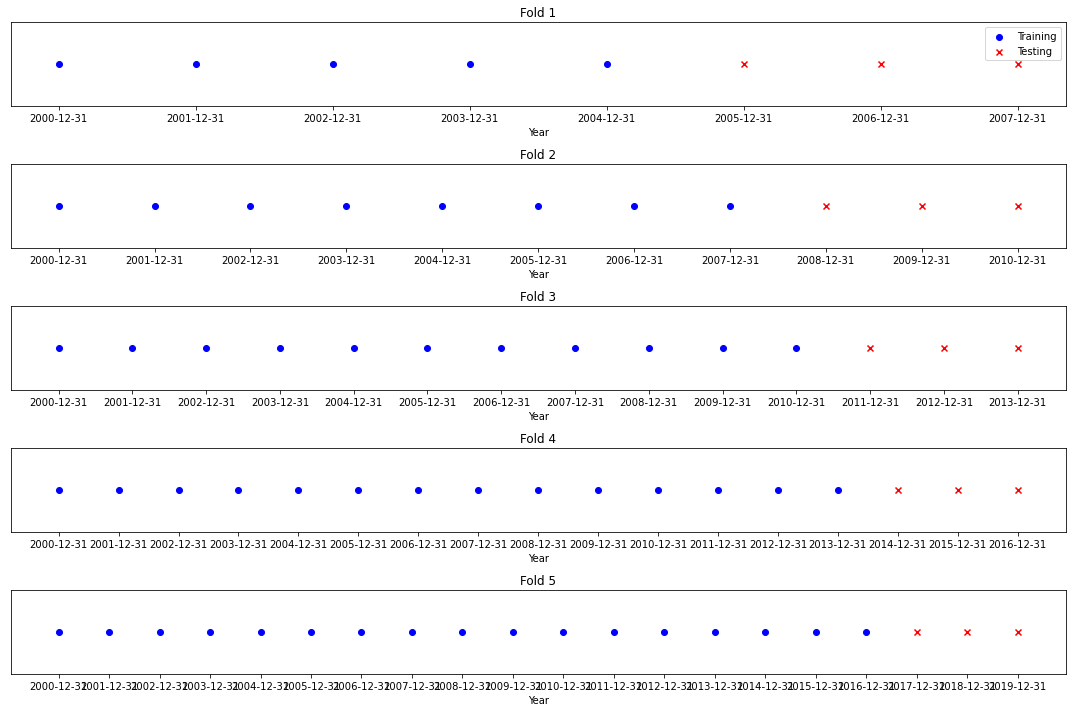

Setting up time series nested cross-validation...
Fold 0: Train/Val years 2000-12-31-2004-12-31, Test years 2005-12-31-2007-12-31
  Train/Val samples: 294, Test samples: 169
Fold 1: Train/Val years 2000-12-31-2007-12-31, Test years 2008-12-31-2010-12-31
  Train/Val samples: 463, Test samples: 155
Fold 2: Train/Val years 2000-12-31-2010-12-31, Test years 2011-12-31-2013-12-31
  Train/Val samples: 618, Test samples: 153
Fold 3: Train/Val years 2000-12-31-2013-12-31, Test years 2014-12-31-2016-12-31
  Train/Val samples: 771, Test samples: 145
Fold 4: Train/Val years 2000-12-31-2016-12-31, Test years 2017-12-31-2019-12-31
  Train/Val samples: 916, Test samples: 160

Performing nested cross-validation with hyperparameter tuning...

Processing fold_0...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
  Best CV RMSE: 8.0560
  Test RMSE: 5.8301, Test R²: 0.5572, Test MAPE: 11.45%
  Test period: 2005-12-31-2007-12-31

Processing fold_1...
Fitting 3 folds for each of 50 candidates,

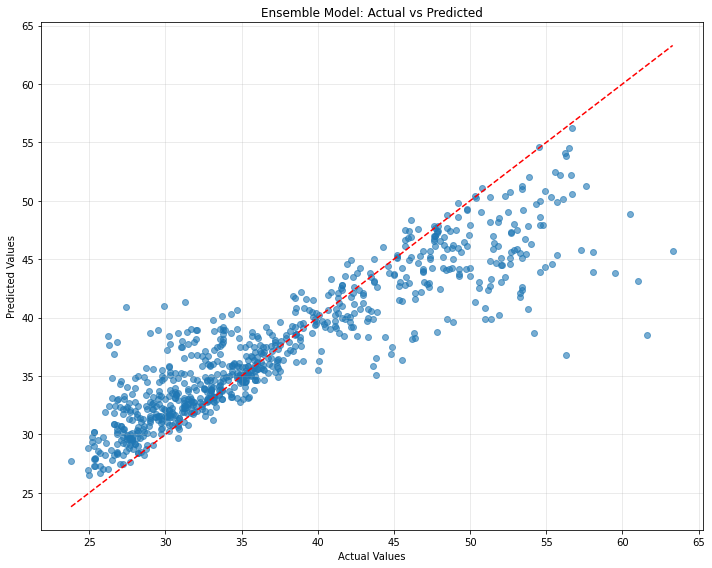


Top 10 ensemble feature importances:


,Indicator Code,Indicator Name,Importance
0,SL.IND.EMPL.FE.ZS,"Employment in industry, female (% of female em...",0.040832
1,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,0.023779
2,IC.REG.COST.PC.ZS,Cost of business start-up procedures (% of GNI...,0.022966
3,EN.GHG.CO2.LU.DF.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - ...,0.022606
4,SE.TER.TCHR.FE.ZS,"Tertiary education, academic staff (% female)",0.020225
5,SH.STA.ODFC.UR.ZS,"People practicing open defecation, urban (% of...",0.013325
6,SH.TBS.DTEC.ZS,"Tuberculosis case detection rate (%, all forms)",0.012692
7,SE.SEC.PROG.MA.ZS,"Progression to secondary school, male (%)",0.011549
8,FB.CBK.DPTR.P3,"Depositors with commercial banks (per 1,000 ad...",0.009976
9,EG.ELC.NGAS.ZS,Electricity production from natural gas source...,0.009261


Top 10 features saved to output/feature_importance_NCV/top10_ensemble_features_GINI_2000_to_2020.csv

Performing SHAP analysis on ensemble model...


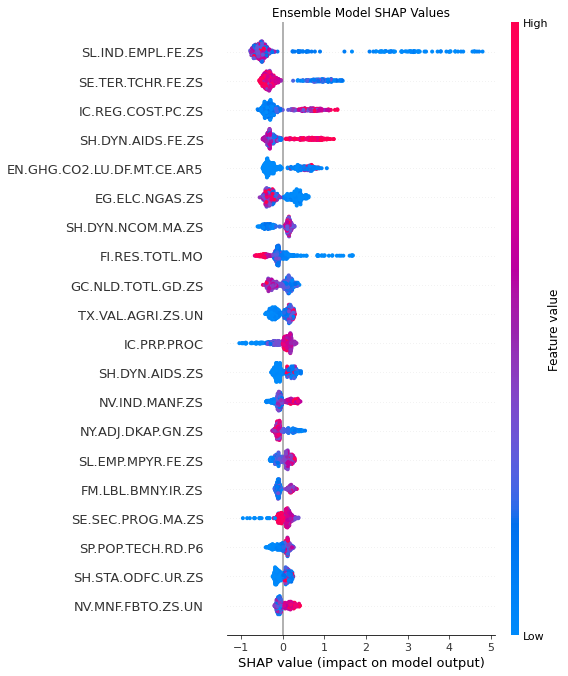

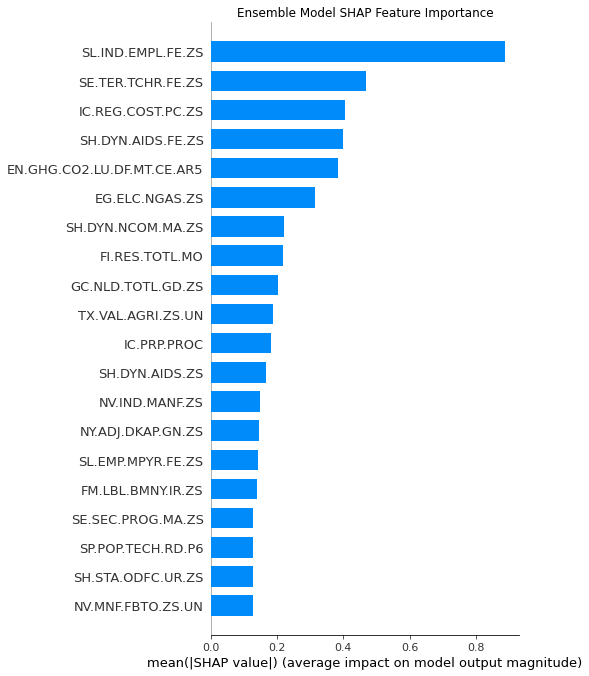

In [7]:
def main():
    """Main function to run the nested CV"""
    try:
        # Load the data
        print("Loading data...")
        data = pd.read_csv(DATA_FILE)
        targets = pd.read_csv(TARGET_FILE)
        print(f"Data loaded. Shape: {data.shape}, Targets shape: {targets.shape}")
        
        # Visualize the time series CV structure
        plot_time_series_cv(data, n_splits=5)
        
        # Perform time series nested cross-validation
        cv_data = time_series_nested_cv(
            data, 
            targets, 
            TARGET, 
            n_splits_outer=5, 
            n_splits_inner=3
        )
        
        # Run hyperparameter tuning with nested CV
        cv_results = perform_nested_cv_hyperparameter_tuning(cv_data)

        # Save the CV results
        joblib.dump(cv_results, TS_CV_FILE)
        print(f"CV results saved to {TS_CV_FILE}")

        # Check if we have a valid ensemble model
        if 'ensemble' in cv_results and cv_results['ensemble'] is not None:
            # Use ensemble model for predictions
            ensemble_model = cv_results['ensemble']
            
            # Save the ensemble model
            joblib.dump(ensemble_model, f'{MODELS_DIR}/xgb_ensemble_model_{FILE_SUFFIX}.pkl')
            print(f"Ensemble model saved to {MODELS_DIR}/xgb_ensemble_model_{FILE_SUFFIX}.pkl")
            
            # Generate predictions for all data points using the ensemble
            all_predictions = []
            all_actuals = []
            
            for fold_name, fold_data in cv_data['cv_splits'].items():
                X_test = fold_data['X_test']
                y_test = fold_data['y_test']
                
                # Generate ensemble predictions
                y_pred = ensemble_model.predict(X_test)
                
                # Store these predictions along with test set info
                test_years = fold_data['test_years']
                test_indices = fold_data['test_indices']
                
                # Create a DataFrame with predictions and actual values
                pred_df = pd.DataFrame({
                    'Fold': [fold_name] * len(y_test),
                    'Test_Period': [f"{min(test_years)}-{max(test_years)}"] * len(y_test),
                    'Actual': y_test,
                    'Predicted': y_pred,
                    'Error': y_test - y_pred,
                    'Squared_Error': (y_test - y_pred) ** 2
                })
                
                # Save predictions for this fold
                pred_df.to_csv(f'{PREDICTIONS_DIR}/ensemble_predictions_{fold_name}_{FILE_SUFFIX}.csv', index=False)
                
                # Collect for global metrics
                all_predictions.extend(y_pred)
                all_actuals.extend(y_test)
            
            # Calculate overall metrics
            overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
            overall_r2 = r2_score(all_actuals, all_predictions)
            
            # Save all predictions to a single file
            all_predictions_df = pd.DataFrame({
                'Actual': all_actuals,
                'Predicted': all_predictions,
                'Error': np.array(all_actuals) - np.array(all_predictions)
            })
            all_predictions_df.to_csv(f'{PREDICTIONS_DIR}/ensemble_all_predictions_{FILE_SUFFIX}.csv', index=False)
            
            print(f"\n=== Ensemble Model Final Evaluation ===")
            print(f"Overall RMSE: {overall_rmse:.4f}")
            print(f"Overall R²: {overall_r2:.4f}")
            
            # Plot actual vs predicted
            plt.figure(figsize=(10, 8))
            plt.scatter(all_actuals, all_predictions, alpha=0.6)
            
            # Add perfect prediction line
            min_val = min(min(all_actuals), min(all_predictions))
            max_val = max(max(all_actuals), max(all_predictions))
            plt.plot([min_val, max_val], [min_val, max_val], 'r--')
            
            plt.title('Ensemble Model: Actual vs Predicted')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'{OUTPUT_DIR}/ensemble_actual_vs_predicted_{FILE_SUFFIX}.png', dpi=300)
            plt.show()
            
            # If feature importance analysis is needed for the ensemble
            # We can take the average feature importance from all models
            ensemble_importances = {}
            for feature in cv_results['feature_columns']:
                feature_importance_values = [cv_results['feature_importances'][fold].get(feature, 0) 
                                            for fold in cv_results['feature_importances']]
                ensemble_importances[feature] = np.mean(feature_importance_values)
            
            # Create and save ensemble feature importances
            ensemble_importances_df = pd.DataFrame({
                'Feature': list(ensemble_importances.keys()),
                'Importance': list(ensemble_importances.values())
            }).sort_values(by='Importance', ascending=False)
            
            ensemble_importances_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/ensemble_feature_importances_{FILE_SUFFIX}.csv', 
                                          index=False)
            
            # Display top features from ensemble
            try:
                feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
                ensemble_importances_with_names = ensemble_importances_df.merge(
                    feature_lookup[['Indicator Code', 'Indicator Name']], 
                    how='left', 
                    left_on='Feature', 
                    right_on='Indicator Code'
                )
                
                print("\nTop 10 ensemble feature importances:")
                top_10_features = ensemble_importances_with_names[['Indicator Code', 'Indicator Name', 'Importance']].head(10)
                display(top_10_features)
                
                # Save top 10 features to CSV
                top_10_features.to_csv(f'{FEATURE_IMPORTANCE_DIR}/top10_ensemble_features_{FILE_SUFFIX}.csv', index=False)
                print(f"Top 10 features saved to {FEATURE_IMPORTANCE_DIR}/top10_ensemble_features_{FILE_SUFFIX}.csv")
            except Exception as e:
                print(f"Error loading indicator lookup: {e}")
                print("\nTop 10 ensemble feature importances:")
                top_10_features = ensemble_importances_df.head(10)
                display(top_10_features)
                
                # Save top 10 features to CSV even if lookup fails
                top_10_features.to_csv(f'{FEATURE_IMPORTANCE_DIR}/top10_ensemble_features_{FILE_SUFFIX}.csv', index=False)
                print(f"Top 10 features saved to {FEATURE_IMPORTANCE_DIR}/top10_ensemble_features_{FILE_SUFFIX}.csv")
            
            # SHAP analysis for ensemble
            try:
                import shap
                print("\nPerforming SHAP analysis on ensemble model...")
                
                # Sample data for SHAP analysis
                all_test_data = []
                for fold_name, fold_data in cv_data['cv_splits'].items():
                    all_test_data.append(fold_data['X_test'])
                
                # Combine test data from all folds
                if all_test_data:
                    X_shap = np.vstack(all_test_data)
                    
                    # Limit size for efficiency
                    if len(X_shap) > 500:
                        np.random.seed(SEED)
                        shap_indices = np.random.choice(len(X_shap), 500, replace=False)
                        X_shap = X_shap[shap_indices]
                    
                    # Get SHAP values for each model in the ensemble
                    shap_values_per_model = []
                    for fold_name, model in cv_results['best_models'].items():
                        if isinstance(model, Pipeline):
                            # Apply scaling first if the model has a scaler
                            X_shap_scaled = model.named_steps['scaler'].transform(X_shap)
                            
                            # Get SHAP values from the XGBoost model
                            explainer = shap.TreeExplainer(model.named_steps['model'])
                            shap_values = explainer.shap_values(X_shap_scaled)
                            shap_values_per_model.append(shap_values)
                    
                    # Average SHAP values across all models
                    if shap_values_per_model:
                        avg_shap_values = np.mean(shap_values_per_model, axis=0)
                        
                        # Save SHAP values
                        shap_values_df = pd.DataFrame(avg_shap_values, columns=cv_results['feature_columns'])
                        shap_values_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/ensemble_shap_values_{FILE_SUFFIX}.csv', index=False)
                        
                        # Plot SHAP summary
                        plt.figure(figsize=(12, 8))
                        shap.summary_plot(
                            avg_shap_values, 
                            X_shap, 
                            feature_names=cv_results['feature_columns'], 
                            show=False
                        )
                        plt.title("Ensemble Model SHAP Values")
                        plt.tight_layout()
                        plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/ensemble_shap_summary_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
                        plt.show()
                        
                        # Create bar plot of SHAP values
                        plt.figure(figsize=(12, 8))
                        shap.summary_plot(
                            avg_shap_values, 
                            X_shap, 
                            feature_names=cv_results['feature_columns'], 
                            plot_type="bar", 
                            show=False
                        )
                        plt.title("Ensemble Model SHAP Feature Importance")
                        plt.tight_layout()
                        plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/ensemble_shap_importance_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
                        plt.show()
                
            except ImportError:
                print("SHAP not available. Skipping SHAP analysis for ensemble.")
            except Exception as e:
                print(f"Error in SHAP analysis: {e}")
                
        else:
            # Fall back to the best individual model if ensemble is not available
            print("\nEnsemble model not available, using best individual model...")
            if 'best_fold' in cv_results and cv_results['best_fold'] is not None:
                best_fold = cv_results['best_fold']
                best_model = cv_results['best_models'][best_fold]
                best_params = cv_results['best_params'][best_fold]
                feature_columns = cv_results['feature_columns']
                
                # Save the best model
                joblib.dump(best_model, BEST_MODEL_FILE)
                print(f"Best model saved to {BEST_MODEL_FILE}")
                
                # Save the best parameters
                with open(BEST_PARAMS_FILE, 'w') as f:
                    json.dump(best_params, f, indent=2)
                print(f"Best parameters saved to {BEST_PARAMS_FILE}")
                
                # Extract feature importances from the best model
                importances = best_model.named_steps['model'].feature_importances_
                feature_importances_df = pd.DataFrame({
                    'Feature': feature_columns,
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)
                
                # Save feature importances
                feature_importances_df.to_csv(BEST_FEATURE_IMPORTANCES_FILE, index=False)
                print(f"Feature importances saved to {BEST_FEATURE_IMPORTANCES_FILE}")
                
                # Get feature names with descriptions
                try:
                    feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
                    feature_importances_with_names = feature_importances_df.merge(
                        feature_lookup[['Indicator Code', 'Indicator Name']], 
                        how='left', 
                        left_on='Feature', 
                        right_on='Indicator Code'
                    )
                    
                    # Display top features
                    print("\nTop 10 feature importances (best model):")
                    display(feature_importances_with_names[['Indicator Code', 'Indicator Name', 'Importance']].head(10))
                except Exception as e:
                    print(f"Error loading indicator lookup: {e}")
                    print("\nTop 10 feature importances (best model):")
                    display(feature_importances_df.head(10))
                
                # Final evaluation on the test set from the best fold
                fold_data = cv_data['cv_splits'][best_fold]
                X_test = fold_data['X_test']
                y_test = fold_data['y_test']
                
                # Generate predictions
                y_pred = best_model.predict(X_test)
                
                # Calculate metrics
                final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                final_r2 = r2_score(y_test, y_pred)
                
                print(f"\nFinal evaluation on test set (years {min(fold_data['test_years'])}-{max(fold_data['test_years'])}):") 
                print(f"RMSE: {final_rmse:.4f}")
                print(f"R²: {final_r2:.4f}")
                
                # Save predictions
                predictions_df = pd.DataFrame({
                    'Actual': y_test,
                    'Predicted': y_pred
                })
                predictions_df.to_csv(BEST_PREDICTIONS_FILE, index=False)
                print(f"Predictions saved to {BEST_PREDICTIONS_FILE}")
            else:
                print("No valid model found in cross-validation.")
    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

# Add this at the bottom of your script to execute the function
if __name__ == "__main__":
    main()